# 研究均值回归的情况

# 市场是随机的，根据均值回归的情况寻找交易机会

几个要点：

1、基于超额收益，排除基准市场的影响

2、以收益率为指标进行对比

3、判断基准为ADF test，随机性测试

4、在此基础上加上Hurst、Half-Life

5、引入基于Kalman方程的beta、alpha

6、在均值回归的基础上，通过多因子回归、行业等方式缩小范围

7、尝试通过时间、基准收益率、股票收益率建模

8、引入成交量建模，几要素建模：过去成交价、过去成交量、当前收益率。预测未来收益率

9、在前面基础上引入ML Model进行尝试


In [36]:
import numpy as np
import pandas as pd
from scipy import stats


import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
import statsmodels.stats as sms

import matplotlib.pyplot as plt
import matplotlib as mpl

import statsmodels.tsa.stattools as ts


# 引入Kalman函数库
from pykalman import KalmanFilter

# 引入纯随机序列检测，只有是非纯随机序列，才能进行检测
from statsmodels.stats.diagnostic import acorr_ljungbox

# 引入时序分析模型进行模型匹配
from statsmodels.tsa.arima_model import ARMA

import itertools

## 自定义的函数

In [37]:
# S1为自变量，S2为因变量
def kalman_beta(S1,S2):
    
    # 观察矩阵
    # 注意：
    # 1、观察到的是sec1数据，sec1是自变量x，sec2是因变量y
    # 2、需要使用add_constant来模拟alpha
    # 3、需要使用np.newaxis来增加维度
    obs_mat = sm.add_constant(S1.values, prepend=False)[:, np.newaxis]

    kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y is 1-dimensional, (alpha, beta) is 2-dimensional
                  initial_state_mean=np.ones(2),
                  initial_state_covariance=np.ones((2, 2)),
                  transition_matrices=np.eye(2),  # 不发生变化，都是单位矩阵
                  observation_matrices=obs_mat,   # 观察矩阵
                  observation_covariance=10**2,
                  transition_covariance=0.01**2 * np.eye(2))
    
    # 相当于使用sec2来进行训练，模拟出beta、alpha
    state_means, state_covs = kf.filter(S2[:, np.newaxis])
    
    # 第一个参数为beta，第二个参数为alpha
    return state_means[-1]


# 函数名：Cadf_test
# 输入参数：
# 1、res_pd:pandas数组，index为日期，列名为“res”
# 输出参数：
# P value：返回test的p值，用于后续监测
# null hypothesis of the Augmented Dickey-Fuller is that there is a unit root
def Cadf_test(res):

    # 使用adf计算adf的值
    cadf = ts.adfuller(res)
    return cadf[1]


# 重要：只有时间序列不是一个白噪声（纯随机序列）的时候，该序列才可做分析
# 函数名：test_stochastic
# 输入参数：
# 1、res_pd:pandas数组，index为日期，列名为“res”
# 输出参数：
# P value：返回test的p值，用于后续监测
# Ljung-Box test for no autocorrelation
# 纯随机性检验,p值小于5%,序列为非白噪声
# H0: 原本的数据都是纯随机序列
# 用于检验某个时间段内的一系列观测值是不是随机的独立观测值
# 如果观测值并非彼此独立，一个观测值可能会在 i 个时间单位后与另一个观测值相关，形成一种称为自相关的关系
# 自相关可以削减基于时间的预测模型（例如时间序列图）的准确性，并导致数据的错误解释。

def test_stochastic(ts):
    p_value = acorr_ljungbox(ts)[1] #lags可自定义
    return p_value[0]


# 进行画图，判断AR、MA的延迟阶数

def tsplot(y, lags=None, figsize=(15, 10), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

In [38]:
# 设置基准股票、对比股票
sec_bench = '000300.XSHG'
sec_stock = '000651.XSHE'

# 设置时间与对比个数
end_date = '2018-12-31'
ncount = 500

# 获得基准的收益率
Price_bench_pd = get_price(sec_bench, count =  ncount, end_date= end_date, frequency='1d', fields='close',fq = "none")['close']
Yield_bench = Price_bench_pd/Price_bench_pd.shift(1)
Yield_bench = Yield_bench.fillna(1)

# 获得股票的收益率
Price_stock_pd = get_price(sec_stock, count =  ncount, end_date= end_date, frequency='1d', fields='close',fq = "none")['close']
Yield_stock = Price_stock_pd/Price_stock_pd.shift(1)
Yield_stock = Yield_stock.fillna(1)

# 超额收益率
Abnormal_Return = Yield_stock - Yield_bench


超额收益率，均值：0.001075；方差：0.015436


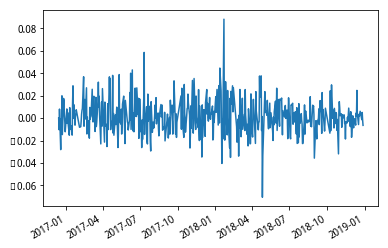

In [39]:
print("超额收益率，均值：%f；方差：%f"%(float(np.mean(Abnormal_Return)),float(np.std(Abnormal_Return))))
Abnormal_Return.plot()

In [40]:
test_stochastic(Abnormal_Return)

0.48231872391869524

H0：原本的数据都是纯随机序列

因为概率大于0.05，所以不可以推翻H0

结论：是序列是纯随机序列

In [41]:
Cadf_test(Abnormal_Return)

0.0

H0：there is unit root

因为概率低于0.05，所以可以推翻H0

结论：不存在Unit Root

/opt/conda/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


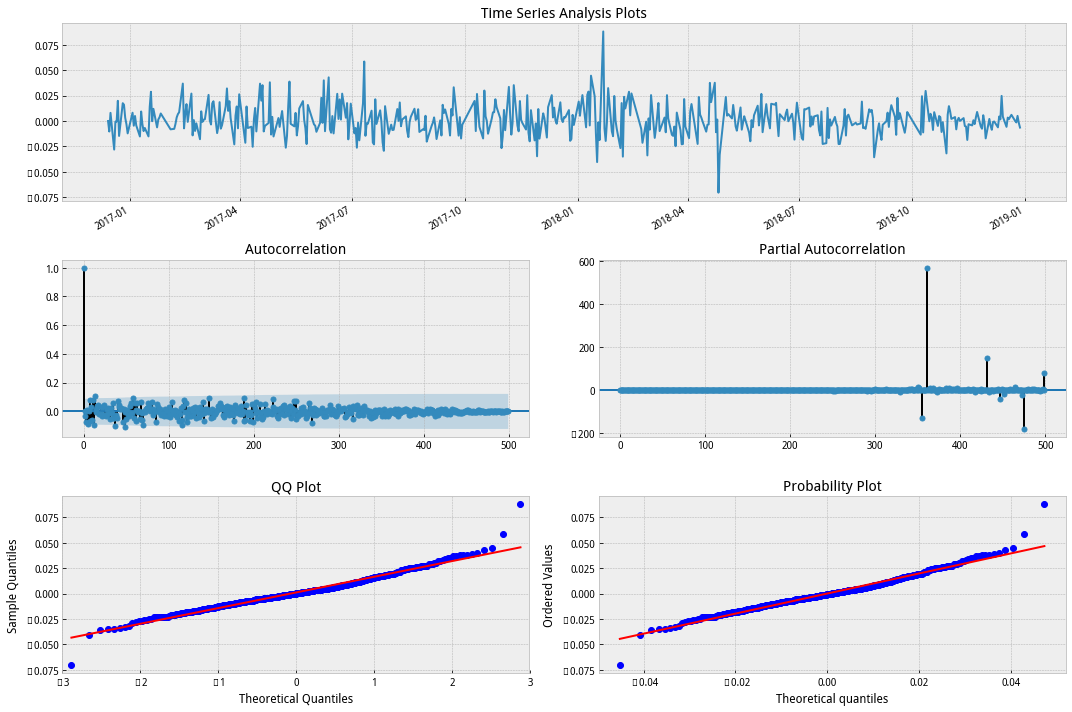

In [42]:
tsplot(Abnormal_Return)

由上图可以看出来基本上没有自相关、偏自相关

序列按照这个情况看序列是具备随机性的特点的

In [43]:
# 计算alpha、beta
# 按照定义：S1为自变量，S2为因变量
# 在此例中，S1为bench，S2为stock
# 意义在于：S1的变化，会引起多少S2的变化

beta_kf = kalman_beta(Yield_bench,Yield_stock)
beta = kalman_beta(Yield_bench,Yield_stock)[0]
alpha = kalman_beta(Yield_bench,Yield_stock)[1]

print("beta为：%f，alpha为：%f"%(float(beta),float(alpha)))

beta为：0.522226，alpha为：0.522208


In [44]:
X = sm.add_constant(Yield_bench)
Y = Yield_stock


model = sm.OLS(Y,X)
results = model.fit()

print(results.params)

print(results.summary())


const   -0.344136
close    1.345272
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                  close   R-squared:                       0.469
Model:                            OLS   Adj. R-squared:                  0.468
Method:                 Least Squares   F-statistic:                     439.1
Date:                Tue, 30 Jul 2019   Prob (F-statistic):           2.24e-70
Time:                        09:57:15   Log-Likelihood:                 1390.2
No. Observations:                 500   AIC:                            -2776.
Df Residuals:                     498   BIC:                            -2768.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c

根据上面的两种线性回归算法，目前来看最小二乘法比较合理一点

# 自定义函数

1、计算half-life系数

2、计算Hurst系数


In [45]:
from collections import Iterable

"""
Half Life test from the Ornstein-Uhlenbeck process 
Source: http://www.pythonforfinance.net/2016/05/09/python-backtesting-mean-reversion-part-2/
"""
# 
def cal_half_life(time_series):
    lag = np.roll(time_series, 1)
    lag[0] = 0
    ret = time_series - lag
    ret[0] = 0

    # adds intercept terms to X variable for regression
    lag2 = sm.add_constant(lag)

    model = sm.OLS(ret, lag2)
    res = model.fit()

    return -np.log(2) / res.params[1]

"""
使用該程式碼對隨機數進行計算Hurst指數時，比較趨近與0.5，即符合隨機
而排序後的資料進行計算則接近於1，即為長期趨勢
不過由於並沒有對資料進行全分類，而是分類的最小集合為每個子集中有3個元素，因此理論上會出現大於1的現象，
不過超出部分比較小，且出現機率並不是很大，因此可以視為1。
数据来源：
https://www.itread01.com/content/1547692778.html
算法来源：
见后面的图片
"""
def cal_Hurst(ts):

    if not isinstance(ts, Iterable):
        print(error)
        return

    n_min, n_max = 2, len(ts)//3
    RSlist = []
    for cut in range(n_min, n_max):
        children = len(ts) // cut
        children_list = [ts[i*children:(i+1)*children] for i in range(cut)]
        L = []
        for a_children in children_list:
            Ma = np.mean(a_children)
            Xta = pd.Series(map(lambda x: x-Ma, a_children)).cumsum()
            Ra = max(Xta) - min(Xta)
            Sa = np.std(a_children)
            rs = Ra / Sa
            L.append(rs)
        RS = np.mean(L)
        RSlist.append(RS)
    return np.polyfit(np.log(range(2+len(RSlist),2,-1)), np.log(RSlist), 1)[0]

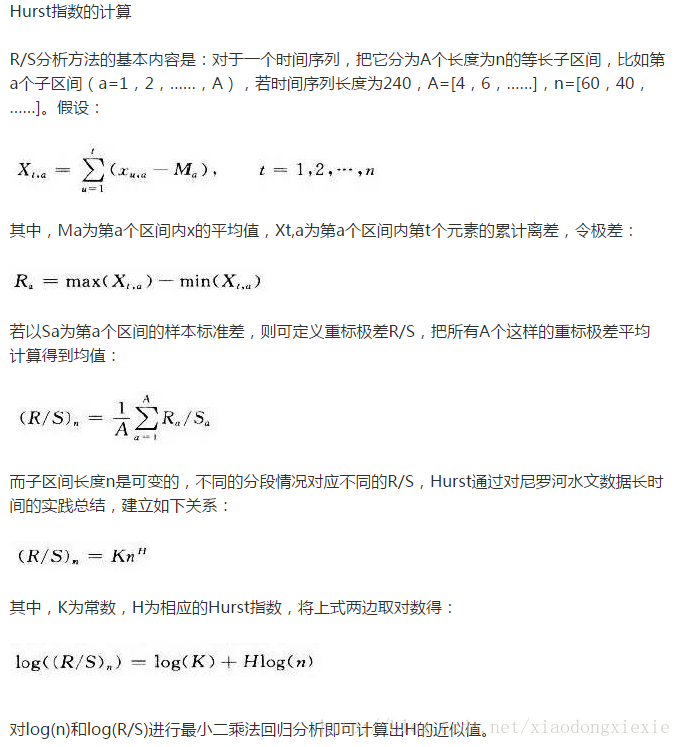

# 思路：

通过工具能够检测相关的参数的基础上，如何套利：

1、通过监测超额收益率，通过超额收益率回归找到相应的买卖点

2、买卖点：A、低于负偏差范围买入；B、高于正偏差范围卖出；C、在其中的话要么持仓，要么空仓

3、候选股票基于多因子回归

4、相关的买卖阈值基于过去60天（或者更长），采用滚动均值的方法

5、通过检测函数检测超额收益率是否存在均值回归的情况，排除不符合情况的股票，但是可能要排除目前的时间（如果目前处于剧烈波动期，则短期内存在均方根）






# 其他内容


1、Hurst函数的其他内容，根据测试发现有一些瑕疵

In [17]:

"""
If Hurst Exponent is under the 0.5 value of a random walk, then the series is mean reverting
Source: https://www.quantstart.com/articles/Basics-of-Statistical-Mean-Reversion-Testing
"""
# 
def cal_hurst(time_series):
    """Returns the Hurst Exponent of the time series vector ts"""
    # Create the range of lag values
    lags = range(2, 100)

    # Calculate the array of the variances of the lagged differences
    tau = [np.sqrt(np.std(np.subtract(time_series[lag:], time_series[:-lag]))) for lag in lags]

    # Use a linear fit to estimate the Hurst Exponent
    poly = np.polyfit(np.log10(lags), np.log10(tau), 1)

    # Return the Hurst exponent from the polyfit output
    return poly[0]*2.0 



def hurst_ernie_chan(p):
    
    lags = range(2,100)
    
    variancetau = []; tau = []

    for lag in lags: 

        #  Write the different lags into a vector to compute a set of tau or lags
        tau.append(lag)

        # Compute the log returns on all days, then compute the variance on the difference in log returns
        # call this pp or the price difference
        pp = subtract(p[lag:], p[:-lag])
        variancetau.append(var(pp))

    # we now have a set of tau or lags and a corresponding set of variances.
    #print tau
    #print variancetau

    # plot the log of those variance against the log of tau and get the slope
    m = polyfit(log10(tau),log10(variancetau),1)

    hurst = m[0] / 2

    return hurst

# 测试

1、测试其他Hurst函数版本的情况

In [13]:
cal_Hurst(Abnormal_Return)

0.497457246183918

In [18]:
cal_hurst(Abnormal_Return)

0.011077126492442484

In [19]:
hurst_ernie_chan(Abnormal_Return)

0.011077126492442484

In [14]:
x=np.arange(0,np.pi*20,1)
y=np.sin(x)

In [15]:
cal_Hurst(y)

0.6683790098314423

In [20]:
hurst_ernie_chan(y)

/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3194: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in log10


nan

In [21]:
cal_hurst(y)

/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()


nan

In [16]:
ts = np.arange(0,10,0.1)
ts
cal_Hurst(ts)

1.0125888313192266

In [22]:
hurst_ernie_chan(ts)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in log10


nan

In [23]:
cal_hurst(ts)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()


nan

In [77]:
cal_half_life(y)

1.5094187257580662

In [78]:
len(x)

629

In [117]:
len(ts)

1000000

In [121]:
hurst(y)

-0.05260088319675887

In [122]:
hurst(ts)

0.0677684880434573

In [125]:
hurst_ernie_chan(ts)

0.067768488043456

In [132]:
calcHurst2(ts)

1.0125888313192266

In [142]:
calcHurst2(Abnormal_Return)

0.497457246183918